In [0]:
%cd /content
from IPython.display import clear_output
#!git clone https://github.com/jmestanza/time_stretching.git

#imports
#!pip install librosa
!pip install webrtcvad
import webrtcvad
!pip install --upgrade librosa
import librosa 
import scipy
import numpy as np
from IPython.display import Audio

clear_output()

In [7]:
#local modules
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/detect_pitch.py
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/modified_psola.py
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/vad.py


--2020-05-23 21:43:35--  https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/detect_pitch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735 (2.7K) [text/plain]
Saving to: ‘detect_pitch.py.1’

detect_pitch.py.1   100%[===================>]   2.67K  --.-KB/s    in 0s      

2020-05-23 21:43:35 (56.4 MB/s) - ‘detect_pitch.py.1’ saved [2735/2735]

--2020-05-23 21:43:38--  https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/modified_psola.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2852 (2.8K)

In [0]:

from modified_psola import modified_psola
from detect_pitch import get_fundamental_frequency
from vad import float2pcm, pcm2float, frame_generator, join_vad_frames, get_vad_frames
from vad import Frame

#audios
!wget "https://raw.githubusercontent.com/vicaub/Pitch-Estimation-and-Voicing-Detection/master/data/fda_ue/rl047.wav"
!wget "https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/input/shh.wav"

clear_output()

In [17]:
fs = 48000

audio_file = "/content/rl047.wav"
test, _ = librosa.load(audio_file, sr=fs, mono=True)
audio_int = float2pcm(test, dtype="int32")

#test para no-sonoro
audio_file2 = "/content/shh.wav"
unvoiced, _ = librosa.load(audio_file2, sr=fs, mono=True)
unvoiced = float2pcm(unvoiced, dtype="int32")
test = np.concatenate((audio_int,unvoiced))

# necesito al menos dos periodos de la señal
#200 = (50+25)+50+(50+25)
#L = 50 # muestras de la ventana
#K = L//2
# tamaño total por observacion
# total = 4*L

#quiero tener 20 milisegundos de señal
T = 20*1e-3
samples = int(T * fs) 
L = samples//4
K = L

Audio(data=test, rate=fs)

In [18]:
vad = webrtcvad.Vad(3)    #0 is the least aggressive about filtering out non-speech, 3 is the most aggressive; 3 pone mas frames en no-sonoros

#divido el audio en frames de 20 milisegundos
frames = frame_generator(20, test, fs)
frames = list(frames)

speech, not_speech, is_frame_speech, frame_len = get_vad_frames(frames, vad, fs)
speed = 2.0


#primero sonoros
lpc_coef = librosa.lpc(speech, 12)
voiced_error = scipy.signal.lfilter(lpc_coef, [1], speech) # obtenemos la señal error a traves del filtrado

# falta obtener frecuencia fundamental para cada region sonora
# porque para una a no es la frec fundamental que para una e, por ejemplo


mean_f0_samples = np.mean(sample_f0s)
#sample_f0s = np.array([ mean_f0_samples for i in range(len(sample_f0s))])


indexes,f0s,sample_f0s = get_fundamental_frequency(voiced_error,is_frame_speech, K, L, fs)


mean_f0_samples = np.mean(sample_f0s)
# #print("Frecuencia fundamental : ",f0," ", sample_f0)
min_dist = fs/500
voiced_audio = modified_psola(voiced_error, mean_f0_samples - 0.16*mean_f0_samples,indexes,sample_f0s, speed, is_frame_speech, frame_len)

voiced_filt = scipy.signal.lfilter([1], lpc_coef, voiced_audio)


Audio(data=voiced_filt, rate=fs)


In [11]:
print(len(voiced_audio),len(test))

95040 192000


In [12]:
len(indexes)

788

In [13]:
len(f0s)

788

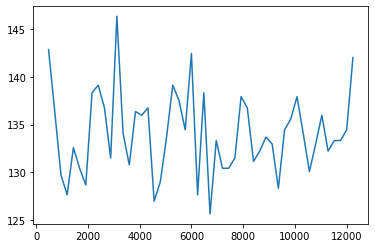

In [14]:
import matplotlib.pyplot as plt

plt.plot(indexes[:50],f0s[:50])